# Changelog:

Last Update: 2022-03-20

Changes:

1. token_to_index returns `vocab[token]`
2. Improve doscstring for `create_vocab`

# Question 2: Natural Language Processing

### Total Points: 46

### Background:
In this question you will fit a set of models with the goal of predicting which text messages (SMS) are spam and which are not. 

You will be experimenting with a variety of different embedding algorithms followed by Logistic Regression.

In [ ]:
!pip install datasets
!python -m spacy download en_core_web_md
!pip install transformers

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## Data Loading, Exploratory Data Analysis and Vocabulary Creation:


In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from typing import List
import numpy as np 
import pandas as pd
from tqdm import tqdm
import torch
np.random.seed(42)

In [ ]:
dataset = load_dataset("sms_spam")
texts = [x["sms"] for x in dataset["train"]]
labels = [x["label"] for x in dataset["train"]]

Reusing dataset sms_spam (/root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_train, X_m, y_train, y_m = train_test_split(texts, labels, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_m, y_m, test_size = 0.5, random_state=0)

In [ ]:
def tokenize(x:str) -> List[str]:
  """
  Takes string as an input and returns a list of tokens. This just splits the string x on whitespace
  """
  return x.lower().split(" ")

##[ 5 points ] Q2.a: Determine / Answer the following: 

*   How many datapoints are in the training set?
*   How many total tokens are there in the data?
*   What % of training examples are spam?
*   What would the accuracy be if for every datapoint we predict it is spam? (explain)





*   2 features in 5574 rows for a total of 11148 datapoints.
*   There are 14,856 unique tokens
*   Approximately 13.4% of the training exmaples are spam
*   The accuracy would be approximately 13.4% because we accurately classify all of these spams and none of the non spam cases

##[4 points ] Q2.b Vocabulary and Frequencies  

Implement the functions `create_count_dict`, and `create_vocab` below that take as input a dataset (list of untokenized strings - one per datapoint), and an integer representing the desired vocabulary size, and returns the vocabulary as a `dict` whose keys are tokens and whose values are indices.

In [ ]:
def create_count_dict(dataset:List[str]) -> dict:
  """
  Given a dataset, returns a dictionary of token counts with tokens being keys, and counts being values
  """
  count_dict = {}

  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(dataset)
  lst = vectorizer.get_feature_names_out()
  x_arr = X.toarray()

  for i in range(len(lst)):
    count_dict[lst[i]] = np.sum(x_arr[:, i])

  return count_dict

def create_vocab(dataset:List[str], vocab_size:int) -> dict:
  """
  Given a dataset, returns a dictionary with tokens as keys and indices as values.

  {"most_common_token": 0, "second_most_common_token": 1, ...}
  """

  # 1. Determine the count of all words
  count_dict = create_count_dict(dataset)

  # 2. Keep the top <vocab_size> tokens
  top = {}
  copy = count_dict.copy()
  for i in range(vocab_size):
      k = max(copy, key=copy.get)
      top[k] = i
      del copy[k] # delete the key we just took

  # 3. Create the token to index dict and fill it with just the top tokens
  vocab_to_index_dict = top.copy()
  
  return vocab_to_index_dict

In [ ]:
# Helper test to at least ensure the constructed vocab is the right size
for i in np.random.randint(low = 100, high = 500, size = 5):
  assert(len(create_vocab(X_train, vocab_size = i)) == i)

In [ ]:
# Create and save your vocab
student_created_count_dict = create_count_dict(X_train)
student_created_vocab = create_vocab(X_train, vocab_size = 500)

##[4 points] Q2.c Token Counts

### Q2.c.a  Is the distribution of token counts below a relatively heavy-tailed distribution?  Would using only the top 30 tokens be sufficient for most applications?

In [ ]:
def visualize_top_token_distribution(count_dict, num_tokens_to_plot):
  """
  Display a barplot of counts of top <num_tokens_to_plot> tokens in the <count_dict>
  """
  df = pd.DataFrame(data={"token": [key for key, _ in count_dict.items()], "count": [value for _, value in count_dict.items()]}).sort_values("count", ascending=False)
  df[:num_tokens_to_plot].plot(x = "token", y = "count", kind="bar")

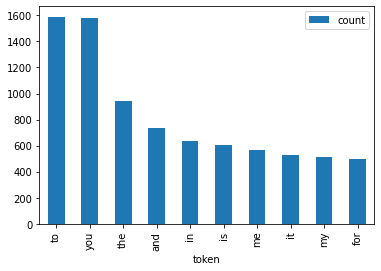

In [ ]:
visualize_top_token_distribution(student_created_count_dict, 10)

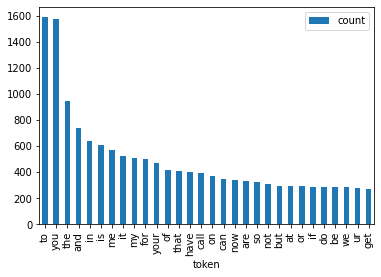

In [ ]:
visualize_top_token_distribution(student_created_count_dict, 30)

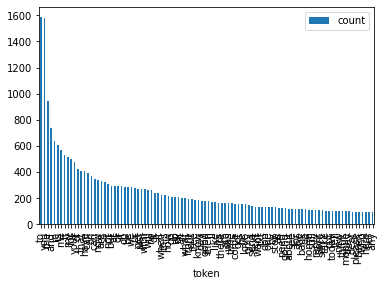

In [ ]:
visualize_top_token_distribution(student_created_count_dict, 100)

### Q2.c.b [2 points] Take a look at the top 10 tokens in the plot above, do you think the embeddings based on those tokens will be informative for our task?


* The distribution of token counts is a relatively heavy (left) tailed distribution. Since token counts decrease drastically, using the top 30 would be sufficient for most applications.

* Embeddings based on the top 10 tokens will not be informative to detecting spam in text messages, because most texts will contain these tokens whether or not they are spam. As a result, we gain no new information.

## Q2.d [ 13 points ] Vocabulary selection and Embeddings

In [ ]:
# NOTHING TO DO HERE, JUST SOME CONVENIENCE FUNCTIONS FOR THE FUTURE
def index_to_token(index:int, vocabulary:dict) -> str:
  """
  Given an index in the vocabulary, and the vocabulary dict with tokens as keys, and indices as values, returns the token that maps to the given index
  """
  if index > len(vocabulary):
    raise ValueError(f"There is no index {index} in the vocabulary")
  inv_vocabulary = {v: k for k, v in vocabulary.items()}
  return inv_vocabulary[index]

def token_to_index(token:str, vocabulary:dict) -> int:
  """
  Given a token, return the index of that token in the vocabulary
  """
  index = vocabulary.get(token)
  if index is None:
    raise ValueError(f"Token: {token} is not in the vocabulary")
  return index

In [ ]:
## NOTHING TO DO HERE

# BoW with our vocab
vectorizer_ours = CountVectorizer(max_features=500, tokenizer=tokenize, vocabulary=student_created_vocab) # Automatic BoW embeddings using your vocab
vectorized_data_ours = vectorizer_ours.fit_transform(X_train) # Embedded data

# Bow with an auto vocab
vectorizer_auto = CountVectorizer(max_features=500) # Automatic BoW embeddings and automatic vocab
vectorized_data_auto = vectorizer_auto.fit_transform(X_train) # Embedded data
VOCAB = vectorizer_auto.vocabulary_ # For convenience

# binary BoW
vectorizer_bbow = CountVectorizer(max_features=500, binary=True, vocabulary=VOCAB) # Automatic binary BoW embeddings using the automatically generated vocab above
vectorized_data_bbow = vectorizer_bbow.fit_transform(X_train) # Embedded data

# TFIDF
tfidf_transformer = TfidfTransformer(smooth_idf=False) # TF-IDF transformer for BoW embeddings
vectorized_data_tfidf_auto = tfidf_transformer.fit_transform(vectorized_data_auto) # Embedded data

### Q2.d.a [ 2 points ] Implement the function `vocabulary_diff` below. It should return a list of tokens that are in `vocab_1` but not in `vocab_2`.

In [ ]:
# Get the differences between our vocabulary and the automatically generated one

def vocabulary_diff(vocab_1:dict, vocab_2:dict) -> List[str]:
  """
  Given 2 vocabularies, returns all the tokens that are present in vocab_1 but not in vocab_2
  """
  vocab_diff = {}

  for key in vocab_1:
    if key not in vocab_2:
      vocab_diff[key] = vocab_1[key]
  return vocab_diff


print(vocabulary_diff(student_created_vocab,VOCAB))
print(vocabulary_diff(VOCAB, student_created_vocab))

{'family': 482, 'food': 484, 'juz': 489}
{'wen': 461, 'weekly': 459, 'wife': 471}


###  Q2.d.b [3 points] Based on the differences between the two vocabularies, which do you think will represent our datapoints better? Why? 

All token counts in VOCAB are lower than in student_created_vocab, so we should take the one that contains more popular tokens.

In [ ]:
# Some convenience constants
DOCUMENT_COUNTS = np.bincount(vectorized_data_bbow.indices, minlength=vectorized_data_bbow.shape[1])
NUM_DATAPOINTS = len(X_train)
VOCAB = vectorizer_auto.vocabulary_

### Q2.d.c [3 points] Implement the `idf` function below which returns the inverse document frequency of a given word as defined by:

$$ IDF(w_j) = log(\frac{N}{N_j}) + 1 $$

where:

* $N$ is the number of datapoints 

* $N_j$ is the number of occurences of word $w_j$ in the data

In [ ]:
def idf(word:str, document_count:np.ndarray=DOCUMENT_COUNTS, num_datapoints:int=NUM_DATAPOINTS) -> float:
  """
  returns the inverse document frequency of a particular word, based on the IDF definition of

  IDF(w_j) = log(N / N_j) + 1

  """
  N = num_datapoints
  idx = token_to_index(word, VOCAB)
  N_j = np.sum(DOCUMENT_COUNTS[idx])
  print("N: ", N, "N_j: ", N_j)
  return np.log(N / N_j) + 1

In [ ]:
for index in np.random.randint(0,500, size=15).tolist():
  print(f"word: {index_to_token(index, VOCAB)}")
  print(f"your idf: {idf(index_to_token(index, VOCAB))}")
  print(f"calculated idf: {tfidf_transformer.idf_[index]}")
  assert np.isclose(tfidf_transformer.idf_[index], idf(index_to_token(index, VOCAB)))

word: head
N:  3901 N_j:  17
your idf: 6.4357748654504405
calculated idf: 6.4357748654504405
N:  3901 N_j:  17
word: ah
N:  3901 N_j:  21
your idf: 6.224465771783233
calculated idf: 6.224465771783233
N:  3901 N_j:  21
word: customer
N:  3901 N_j:  35
your idf: 5.713640148017243
calculated idf: 5.713640148017243
N:  3901 N_j:  35
word: dont
N:  3901 N_j:  98
your idf: 4.684020730836085
calculated idf: 4.684020730836085
N:  3901 N_j:  98
word: where
N:  3901 N_j:  82
your idf: 4.862268962242403
calculated idf: 4.862268962242403
N:  3901 N_j:  82
word: it
N:  3901 N_j:  423
your idf: 3.2216160304603783
calculated idf: 3.2216160304603783
N:  3901 N_j:  423
word: po
N:  3901 N_j:  24
your idf: 6.0909343791587105
calculated idf: 6.0909343791587105
N:  3901 N_j:  24
word: weekend
N:  3901 N_j:  22
your idf: 6.177945756148341
calculated idf: 6.177945756148341
N:  3901 N_j:  22
word: co
N:  3901 N_j:  39
your idf: 5.60542656337701
calculated idf: 5.60542656337701
N:  3901 N_j:  39
word: sms
N: 

### Q2.d.d [2 points] Implement a binary Bag of Words embedding function that takes in a list of token and a vocab, and returns a numpy array corresponding to the embedding vector

In [ ]:
def binary_BoW_embedder(list_of_tokens:List[str], vocab:dict) -> np.ndarray:
  """
  Creates a binary Bag of Words embedding of a datapoint represented as a list of tokens, using the vocab
  """
  # Hint: you may want to start with np.zeros()
  embedding = np.zeros(len(vocab))
  for i in range(len(list_of_tokens)):
    embedding[token_to_index(list_of_tokens[i], vocab)] = 1

  return embedding

In [ ]:
for test_num in range(15):
  sample_token_indices = np.random.randint(0,500, size=10)
  input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
  input_text_as_str = " ".join(input_text)
  print(f"text: {input_text}")
  if test_num == 0:
    print(f"your embedding: {binary_BoW_embedder(input_text, VOCAB)}")
    print(f"calculated embedding: {vectorizer_bbow.transform([input_text_as_str]).toarray()}")
  assert np.isclose(binary_BoW_embedder(input_text, VOCAB), vectorizer_bbow.transform([input_text_as_str]).toarray()).all()
  print("Success!")

text: ['or', 'maybe', 'really', 'yeah', 'time', 'nothing', 'stuff', 'hello', 'wait', 'morning']
your embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.

### Q2.d.e [2 points] Implement a Bag of Words embedding function that takes in a list of token and a vocab, and returns a numpy array corresponding to the embedding vector

In [ ]:
def BoW_embedder(list_of_tokens, vocab):
  """
  Creates a binary Bag of Words embedding of a datapoint represented as a list of tokens, using the vocab
  """
  # Hint: You may want to start with np.zeros()
  embedding = np.zeros(len(vocab))
  for i in range(len(list_of_tokens)):
    embedding[token_to_index(list_of_tokens[i], vocab)] += 1

  return embedding

In [ ]:
for test_num in range(15):
  sample_token_indices = np.random.randint(199,204, size=10)
  input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
  input_text_as_str = " ".join(input_text)
  print(f"text: {input_text}")
  if test_num == 0:
    print(f"your embedding: {BoW_embedder(input_text, VOCAB)}")
    print(f"calculated embedding: {vectorizer_auto.transform([input_text_as_str]).toarray()}")
  assert np.isclose(BoW_embedder(input_text, VOCAB), vectorizer_auto.transform([input_text_as_str]).toarray()).all()
  print("Success!")

text: ['hours', 'hope', 'holiday', 'hours', 'home', 'hope', 'holiday', 'home', 'home', 'hour']
your embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 2. 3. 2. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

##Q2.e [11 points] Model Fitting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
logreg_auto = LogisticRegression(random_state=1).fit(vectorized_data_auto, y_train)
logreg_bbow = LogisticRegression(random_state=1).fit(vectorized_data_bbow, y_train)
logreg_tfidf = LogisticRegression(random_state=1).fit(vectorized_data_tfidf_auto, y_train)

### Q2.e.a [3 points] Evaluation Metrics
Below you can see a set of simple accuracy scores: 

https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

In what situation would accuracy be a good evaluation metric? In what situation it wouldn't? 

In [ ]:
print(f" All 1s; accuracy on validation data: {accuracy_score(y_val, np.ones_like(y_val))}")

print(f" All 0s; accuracy on validation data: {accuracy_score(y_val, np.zeros_like(y_val))}")

print(f" Logistic Regression on BoW embedding; accuracy on validation data: {accuracy_score(y_val, logreg_auto.predict(vectorizer_auto.transform(X_val)))}")

print(f" Logistic Regression on binary BoW embedding; accuracy on validation data: {accuracy_score(y_val, logreg_bbow.predict(vectorizer_bbow.transform(X_val)))}")

print(f" Logistic Regression on TF-IDF embedding; accuracy on validation data: {accuracy_score(y_val, logreg_tfidf.predict(tfidf_transformer.transform(vectorizer_auto.transform(X_val))))}")


 All 1s; accuracy on validation data: 0.1255980861244019
 All 0s; accuracy on validation data: 0.8744019138755981
 Logistic Regression on BoW embedding; accuracy on validation data: 0.9772727272727273
 Logistic Regression on binary BoW embedding; accuracy on validation data: 0.9808612440191388
 Logistic Regression on TF-IDF embedding; accuracy on validation data: 0.972488038277512


When comparing the Binary BoW, BoW, and TF-IDF models with each other, accuracy is a good evaluation metric, because it tells us how good each model is at guessing the classification.

However, if we tried to compare the first two models (All 0s and All 1s) with each other, accuracy is not a good metric to use. In this case, all it represents is the proportion of 0s (87%) and 1s (13%) in the sample set. If we were to say that All 0s is a better model because it has a higher accuracy, that is not true because both models intrinsically perform the same.

Lastly, in the case of comparing one of the first two models (All 0s or All 1s) with one of the last three models, this metric doesn’t capture the whole picture. If we say that the All 0s model performed decently, only slightly worse than one of the 3 learning models, and so it is suitable, we would be incorrect, again because our sample data happened to include far more 0s than ones, not reflecting the true performance of the model. 

This is likely in part due to the fact that the vast majority of text messages in general are likely to not be spam, but the more data available, the better picture we get about the performance of the All 1s and All 0s models.

### Q2.e.b [8 points] Answer the following in one-two sentences (2 points each)

* What is the interpretation of coefficient $\beta_j$ with $j > 1$ (so not the intercept) in the Logistic regression model fit on the binary BoW embeddings?

* What is the interpretation of coefficient $\beta_j$ with $j > 1$ (so not the intercept) in the Logistic regression model fit on the BoW embeddings?

* If we were to include 1-st order interaction terms in our Logistic Regression model fit on binary BoW embeddings, what would be the interpretation of a coefficient for that interaction ?

* Is the above different from fitting a Logistic Regression on a combination of unigrams and bigrams (1-grams, and 2-grams)? Explain.

*   $\beta_j$ is the probability of a message being spam given presence of the $j$th token
*   $\beta_j$ is the probability of a message being spam as above, with weight depending on the count of $j$th token
*   The likliness of that interaction to affect the probabilty of a message being spam
*   It is different because the length of the token accounts for phrases and mulitple worded terms which the above lacks.

## Q2.f [4 points] Word Vectors

Below we will be using a set of pre-trained word embeddings from the SpaCy library. For the purpose of the questions below, assume that they were trained
using a Skip-Gram objective as described in lecture.

In [ ]:
# This installs a full pipeline of tokenizer -> embedder with additional components.

import spacy
spacy_pipeline = spacy.load('en_core_web_md') # If this line produces an error,
# you might need to re-start the runtime after running the first cell.

### Q2.f.a [2 points] Implement the function get_document_embedding_from_spacy below to return the document embedding as the average of all vector embeddings.

You are not allowed to use `tokens.vector` in your functions, but you can check against it that your solution is accurate

In [ ]:
def get_document_embedding_from_spacy(text:str) -> np.ndarray:
  """
  returns the embedding vector representing the entire text by averaging the 
  word level embeddings.

  !! DO NOT USE tokens.vector directly!! 
  """
  tokens = spacy_pipeline(text)

  # Hint: you can iterate over each token in `tokens` and access the underlying vector with .vector
  word_embedding = np.zeros((len(tokens), len(tokens[1].vector)))
  for i in range(len(tokens)):
    word_embedding[i] = tokens[i].vector
  document_embedding = np.mean(word_embedding, axis=0)

  return document_embedding

In [ ]:
# TEST FOR THE get_document_embedding_from_spacy function
for test_num in range(15):
  sample_token_indices = np.random.randint(0,500, size=10)
  input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
  input_text_as_str = " ".join(input_text)
  print(f"text: {input_text}")
  if test_num == 0:
    print(f"your embedding: {get_document_embedding_from_spacy(input_text_as_str)}")
    print(f"calculated embedding: {spacy_pipeline(input_text_as_str).vector}")
  assert np.isclose(get_document_embedding_from_spacy(input_text_as_str), spacy_pipeline(input_text_as_str).vector).all()
  print("Success!")

text: ['if', 'waiting', 'good', 'world', 'getting', 'bus', 'nice', 'thats', 'morning', 'on']
your embedding: [ 5.77830383e-02  1.94456361e-01 -2.19950904e-01 -3.78643638e-02
  9.56407272e-02  4.53359976e-02  8.85836272e-03 -1.45602456e-01
 -4.53000917e-02  2.39745457e+00 -2.43452186e-01 -1.15168364e-01
  7.67919083e-02 -3.75229097e-02 -3.66774237e-01 -2.93011538e-02
 -1.47375274e-01  1.11763364e+00 -1.02154727e-01 -1.30321994e-02
 -3.26862729e-02  1.12621544e-01 -8.88800011e-03 -4.74057275e-02
  5.76359115e-02 -2.09286190e-02 -2.14628641e-02 -1.40164999e-01
  1.13103100e-01 -4.19531810e-02 -1.00099800e-01 -1.27693551e-01
 -6.14572579e-03  2.54744724e-02  8.97536383e-02  3.00560014e-02
  7.57170917e-02  6.76214556e-02 -1.65086003e-01 -7.52437719e-02
  1.71010007e-02 -2.83627290e-02 -8.08163607e-02  5.34527268e-02
  2.79981866e-02  1.70090825e-01 -1.20148744e-01 -4.45693623e-02
 -1.18348817e-01 -6.59102186e-02 -1.07713271e-01  7.12039999e-02
  1.02204530e-02  1.63156184e-01  3.67557429e-

In [ ]:
# This might take around 1 minute to run
X_train_spacy = np.vstack([get_document_embedding_from_spacy(x) for x in X_train])
X_valid_spacy = np.vstack([get_document_embedding_from_spacy(x) for x in X_val])
logreg_w2v = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_spacy, y_train)
print(f" Logistic Regression on Word2Vec embedding; accuracy on validation data: {accuracy_score(y_val , logreg_w2v.predict(X_valid_spacy))}")

 Logistic Regression on Word2Vec embedding; accuracy on validation data: 0.9677033492822966


### Q2.f.b [2 points] Implement the function get_document_embedding_from_spacy_alt below to return the document embedding based on the token vectors.

Feel free to let your imagination run, or go with simplicity. Don't use the average as above. Feel free to play around and see what works and what doesn't.

In [ ]:
def get_document_embedding_from_spacy_alt(text:str) -> np.ndarray:
  """
  returns the embedding vector representing the entire text by whatever means you
  would like based on the token level embeddings
  """
  tokens = spacy_pipeline(text)
  
  document_embedding = np.amax(tokens.vector, axis=0) # using the columnwise max

  return document_embedding

In [ ]:
# This might take around a 1 minute
X_train_spacy_alt = np.vstack([get_document_embedding_from_spacy_alt(x) for x in X_train])
X_valid_spacy_alt = np.vstack([get_document_embedding_from_spacy_alt(x) for x in X_val])
logreg_w2v_alt = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_spacy_alt, y_train)
print(f" Logistic Regression on Word2Vec alternative embedding; accuracy on validation data: {accuracy_score(y_val , logreg_w2v_alt.predict(X_valid_spacy_alt))}")

## Combining Embeddings [Free]

In [ ]:
X_train_combined = np.hstack((X_train_spacy, vectorized_data_auto.toarray()))
X_val_combined = np.hstack((X_valid_spacy, vectorizer_auto.transform(X_val).toarray()))
logreg_combined = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_combined, y_train)
print(f" Logistic Regression on combined W2V and BoW embeddings; accuracy on validation data: {logreg_combined.score(X_val_combined, y_val)}")

##[2 points] Q2.g Transformer Model

Below we will be using embeddings produced by a "Transformer" model (we will learn more about these in week 12/13), for the embedding of each token, it aims to incorporate not only the meaning of the token, but also the specific context in which it occurs here, with the context being a fixed window of size 512.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection") # This model has been trained on this data

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection", output_hidden_states = True)

### Q2.g.a [2 points] Finish the implementation of get_embedding_from_transformer to produce a document level embedding given some text. 

In [ ]:
def get_embedding_from_transformer(text:str) -> np.ndarray:
  """
  Returns an embedding from a transformer model produced by averaging the token level embeddings
  """
  tokenized = tokenizer([text])
  for key, value in tokenized.items():
    tokenized[key] = torch.LongTensor(value)
  with torch.no_grad():
    token_embeddings = model.forward(**tokenized)["hidden_states"][0].numpy()[0]
  # print(token_embeddings.shape)
  document_embedding = np.mean(token_embeddings, axis=0)
  return document_embedding

In [ ]:
# JUST SOME TESTING THAT IT RUNS AND PRODUCES THE RIGHT SIZE
for e in [get_embedding_from_transformer(x) for x in X_train[:3]]:
  assert e.shape == (128,)

In [ ]:
# This might take around a 1 minute
X_train_transformer = np.vstack([get_embedding_from_transformer(x) for x in X_train])
X_valid_transformer = np.vstack([get_embedding_from_transformer(x) for x in X_val])
logreg_transformer = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_transformer, y_train)
print(f" Logistic Regression on Transformer embedding accuracy on validation: {logreg_transformer.score(X_valid_transformer, y_val)}")

## Q2.h [3 points] Which spam detection method worked best? Why do you think that is? What are some considerations you would need to make to use this model in practice? 

We say that the spam detection method that worked the best is the one with the highest accuracy. Thus, the best spam detection method based on our findings is the Logistic Regression on Transformer embedding. 

That is because it aims to incorporate not only the meaning of the token, but also the specific context in which it occurs.

On the philosophy of validation and accuracy as metrics towards analyzing the performance of models in spam detection, we may sufficiently conclude that the foremost requirement is a substantial amount of sample data in both spam and non-spam cases.